# Analysis of Antibiotics Prescription and Hospitalisation Risk

In [354]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
%matplotlib inline

In [355]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [356]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [357]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [358]:
# function to generate histogram plots
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [359]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [360]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [361]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

TypeError: 'Series' object is not callable

In [ ]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,34200,3600,3600,3600,3600,103,3600,3600,0.0,0.0,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000
unique,36,36,36,13,7,29,1036,1037,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
top,2019-08,2019-04,2019-08,2018-10,2018-11,2019-01-12,2021-04-21,2019-03-26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01
freq,1050,123,128,337,612,11,11,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,5013.894222,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,2871.273888,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2536.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5010.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7492.000000,NaN


In [350]:
data.columns

Index(['Treatment', 'Improved'], dtype='object')

In [351]:
# define dictionaries

dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [352]:
# reoplace values of dictionaries with existing ones

data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [353]:
#prep before plot

data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# Negative GP consultations mean what? Shall I remove them?

KeyError: 'age'

#### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [189]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [190]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

3.0     4762
2.0     4707
4.0     4214
1.0     4190
0.0     3492
5.0     3155
6.0     2833
7.0     2226
8.0     1713
9.0     1333
10.0    1109
11.0     814
12.0     562
13.0     368
14.0     183
15.0     130
16.0      87
17.0      57
18.0      31
19.0      19
20.0       7
21.0       7
22.0       1
Name: CCI, dtype: int64

In [191]:
data.age_cat

0        65-74
1        45-54
2          0-4
3        55-64
4        45-54
         ...  
35995      0-4
35996    25-34
35997      0-4
35998      75+
35999    65-74
Name: age_cat, Length: 36000, dtype: object

In [192]:
# categorising 
data['BMI_cat'] = pd.cut(data['bmi'], right=False, bins=[0,18.5,25,30,200], labels=['Low', 'Moderate', 'High', 'very high'])
data['gp_count_cat'] = pd.cut(data['gp_count'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,7,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

## 2- Plots

### 2-1- Continuous factors

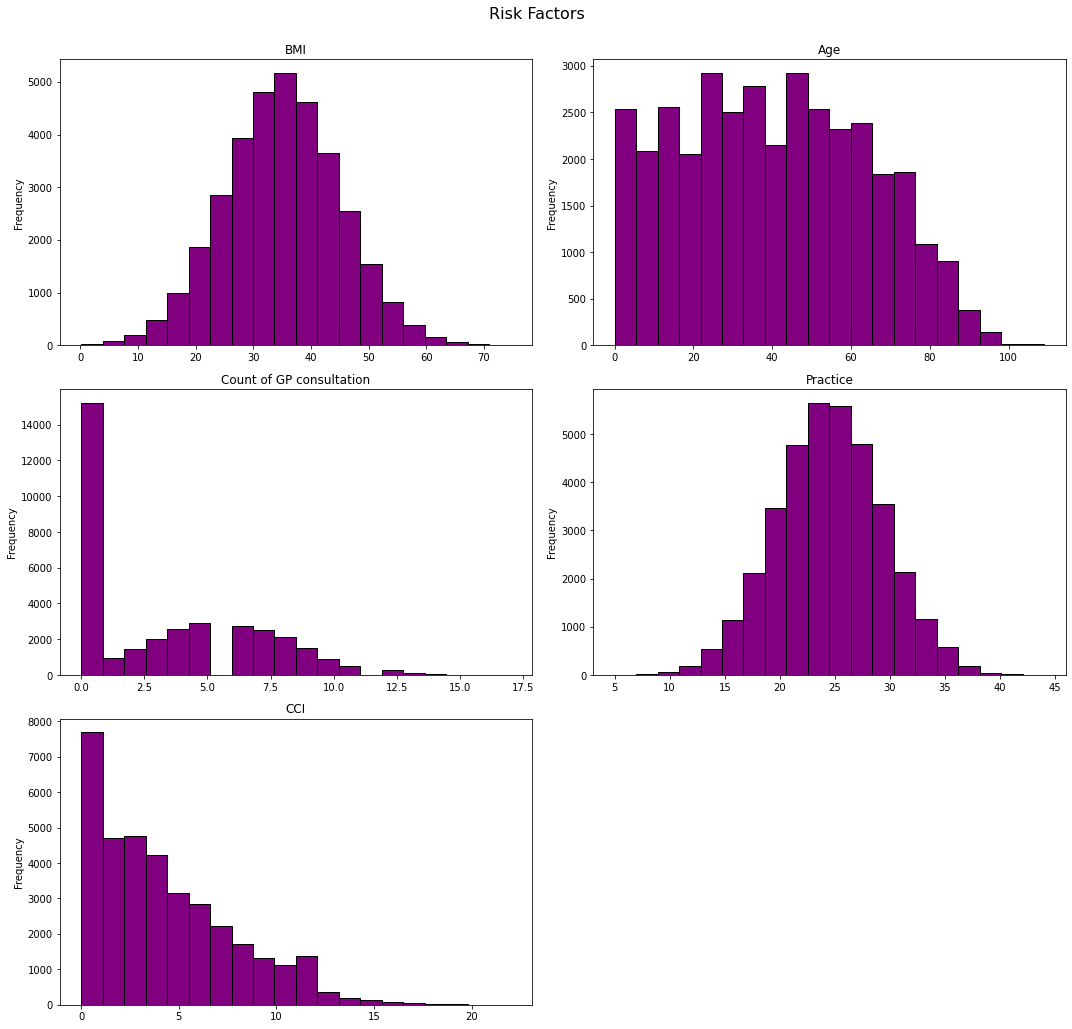

In [17]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

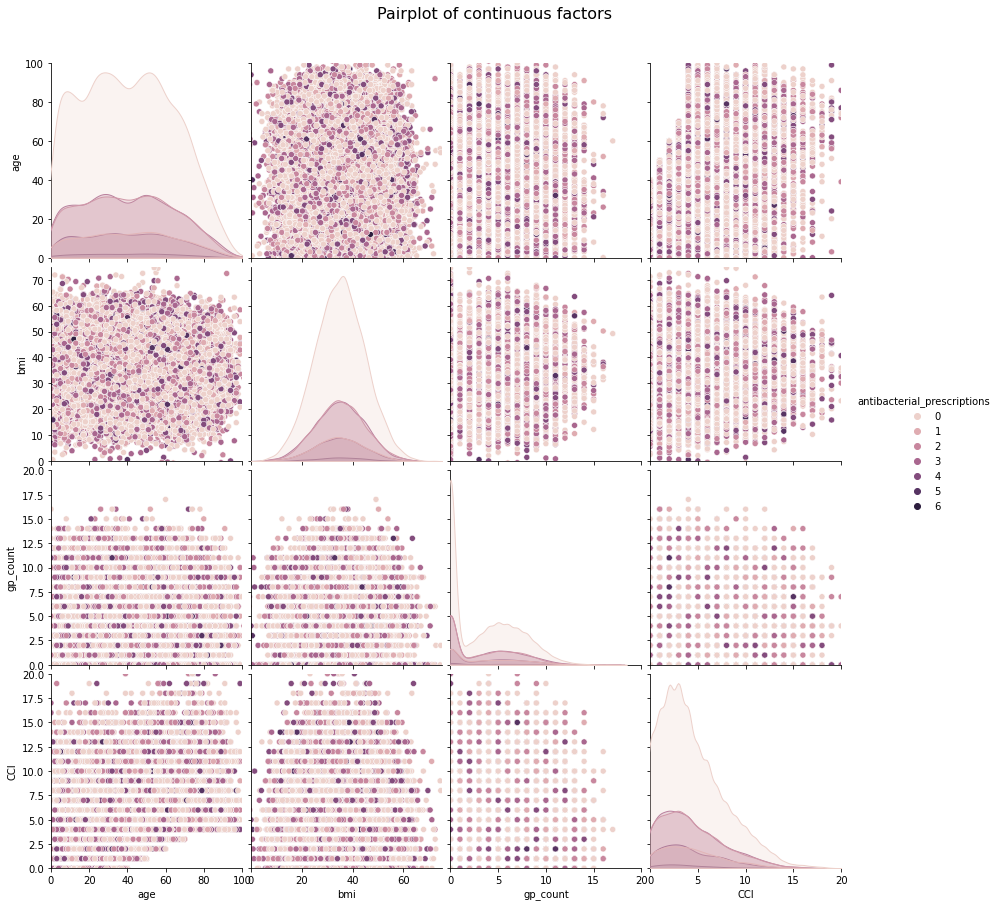

In [17]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'antibacterial_prescriptions', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
#                'scatter_kws': {'alpha': 0.2}}, 
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

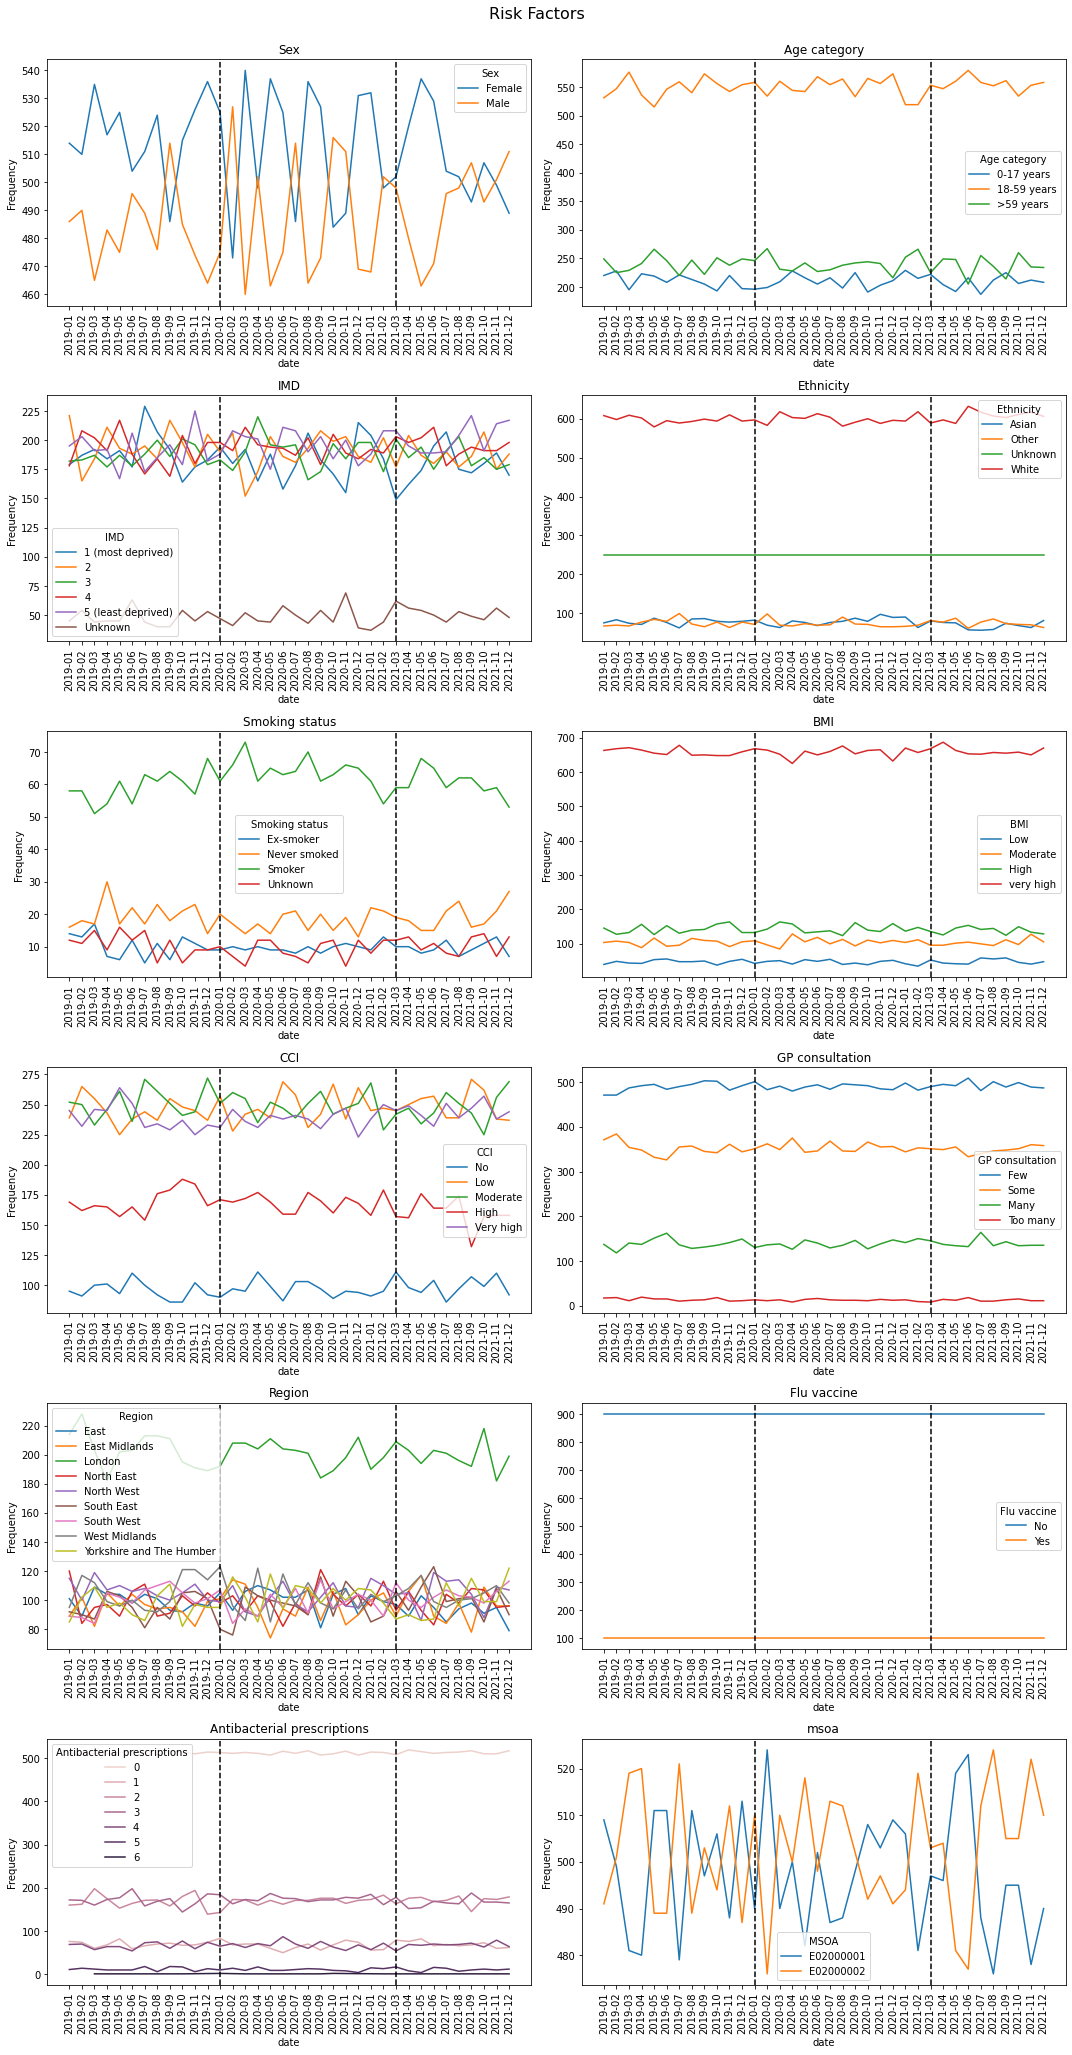

In [193]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_prescriptions', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## 3- Hospital admissions related to infections 

### 3-1- Data preparation for hospital admission prediction with negative binomial regression
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission. 

In [194]:
data['uti_date_1'] = data['uti_date_1'].astype('datetime64[ns]')
data['uti_date_2'] = data['uti_date_2'].astype('datetime64[ns]')
data['uti_date_3'] = data['uti_date_3'].astype('datetime64[ns]')
data['uti_date_4'] = data['uti_date_4'].astype('datetime64[ns]')

data['lrti_date_1'] = data['lrti_date_1'].astype('datetime64[ns]')
data['lrti_date_2'] = data['lrti_date_2'].astype('datetime64[ns]')
data['lrti_date_3'] = data['lrti_date_3'].astype('datetime64[ns]')
data['lrti_date_4'] = data['lrti_date_4'].astype('datetime64[ns]')

data['primary_care_covid'] = data['primary_care_covid'].astype('datetime64[ns]')
data['sgss_positive'] = data['sgss_positive'].astype('datetime64[ns]')
data['admitted_date'] = data['admitted_date'].astype('datetime64[ns]')

In [195]:
data['delta_uti_1_admitted'] = (data['admitted_date'] - data['uti_date_1']).dt.days
data['delta_uti_2_admitted'] = (data['admitted_date'] - data['uti_date_2']).dt.days
data['delta_uti_3_admitted'] = (data['admitted_date'] - data['uti_date_3']).dt.days
data['delta_uti_4_admitted'] = (data['admitted_date'] - data['uti_date_4']).dt.days

data['delta_lrti_1_admitted'] = (data['admitted_date'] - data['lrti_date_1']).dt.days
data['delta_lrti_2_admitted'] = (data['admitted_date'] - data['lrti_date_2']).dt.days
data['delta_lrti_3_admitted'] = (data['admitted_date'] - data['lrti_date_3']).dt.days
data['delta_lrti_4_admitted'] = (data['admitted_date'] - data['lrti_date_4']).dt.days

In [196]:
data['delta_uti_1_admitted'] = data['delta_uti_1_admitted'][(data['delta_uti_1_admitted'] < 30) & (data['delta_uti_1_admitted'] > 0)]
data['delta_uti_2_admitted'] = data['delta_uti_2_admitted'][(data['delta_uti_2_admitted'] < 30) & (data['delta_uti_2_admitted'] > 0)]
data['delta_uti_3_admitted'] = data['delta_uti_3_admitted'][(data['delta_uti_3_admitted'] < 30) & (data['delta_uti_3_admitted'] > 0)]
data['delta_uti_4_admitted'] = data['delta_uti_4_admitted'][(data['delta_uti_4_admitted'] < 30) & (data['delta_uti_4_admitted'] > 0)]

data['delta_lrti_1_admitted'] = data['delta_lrti_1_admitted'][(data['delta_lrti_1_admitted'] < 30) & (data['delta_lrti_1_admitted'] > 0)]
data['delta_lrti_2_admitted'] = data['delta_lrti_2_admitted'][(data['delta_lrti_2_admitted'] < 30) & (data['delta_lrti_2_admitted'] > 0)]
data['delta_lrti_3_admitted'] = data['delta_lrti_3_admitted'][(data['delta_lrti_3_admitted'] < 30) & (data['delta_lrti_3_admitted'] > 0)]
data['delta_lrti_4_admitted'] = data['delta_lrti_4_admitted'][(data['delta_lrti_4_admitted'] < 30) & (data['delta_lrti_4_admitted'] > 0)]

In [197]:
data['Infection_count'] = np.nan
col0 = data.columns.get_loc('Infection_count')

col1 = data.columns.get_loc('delta_uti_1_admitted')
col2 = data.columns.get_loc('delta_uti_2_admitted')
col3 = data.columns.get_loc('delta_uti_3_admitted')
col4 = data.columns.get_loc('delta_uti_4_admitted')
col5 = data.columns.get_loc('delta_lrti_1_admitted')
col6 = data.columns.get_loc('delta_lrti_2_admitted')
col7 = data.columns.get_loc('delta_lrti_3_admitted')
col8 = data.columns.get_loc('delta_lrti_4_admitted')


for idx, x in enumerate(data['Infection_count']):
    n=0
    #comorbidity component
    if data.iat[idx, col1] > 0:
        n=n+1
    if data.iat[idx, col2] > 0:
        n=n+1 
    if data.iat[idx, col3] > 0:
        n=n+1 
    if data.iat[idx, col4] > 0:
        n=n+1
    if data.iat[idx, col5] > 0:
        n=n+1
    if data.iat[idx, col6] > 0:
        n=n+1
    if data.iat[idx, col7] > 0:
        n=n+1
    if data.iat[idx, col8] > 0:
        n=n+1
    data.iat[idx, col0]=n

data.Infection_count.value_counts()

# data.loc[data.Infection_count == 2]

0.0    35772
1.0      227
2.0        1
Name: Infection_count, dtype: int64

In [198]:
# add a column with the closest duration from hospitalisation
data['Infection_admitted_min_delta'] = data[['delta_uti_1_admitted','delta_uti_2_admitted', 'delta_uti_3_admitted', 
                                            'delta_uti_4_admitted', 'delta_lrti_1_admitted', 'delta_lrti_2_admitted',
                                            'delta_lrti_3_admitted', 'delta_lrti_4_admitted']].min(axis=1)

#data['Infection_admitted_min_delta'].value_counts()

In [199]:
print(f'Data shape is: {data.shape}')

Data shape is: (36000, 91)


In [201]:
# calculation of delta of hospital admission date and sgss diagnosis of covid
#data['delta_primary_care_covid_admitted'] = (data['admitted_date'] - data['primary_care_covid']).dt.days
data['delta_primary_care_covid_admitted'] = (data['admitted_date'] - data['sgss_positive']).dt.days
data['delta_primary_care_covid_admitted'].value_counts()

-307.0    4
 6.0      4
 11.0     4
 360.0    4
 212.0    4
         ..
-271.0    1
-365.0    1
 746.0    1
-265.0    1
 692.0    1
Name: delta_primary_care_covid_admitted, Length: 785, dtype: int64

In [203]:
# calculate absolute values for all rows in delta_primary_care_covid_admitted column
data['delta_primary_care_covid_admitted_abs'] = data['delta_primary_care_covid_admitted'].abs()

data['delta_primary_care_covid_admitted_abs'].value_counts()

360.0    7
307.0    6
11.0     5
119.0    5
212.0    5
        ..
36.0     1
432.0    1
876.0    1
573.0    1
692.0    1
Name: delta_primary_care_covid_admitted_abs, Length: 615, dtype: int64

In [204]:
data['delta_primary_care_covid_admitted_abs'].value_counts().sum()

1033

In [205]:
data['delta_primary_care_covid_admitted_binary'] = data['delta_primary_care_covid_admitted_abs'].mask(data['delta_primary_care_covid_admitted_abs'] > 0, 1)
data['delta_primary_care_covid_admitted_binary'] = data['delta_primary_care_covid_admitted_binary'].fillna(0)
data['delta_primary_care_covid_admitted_binary'].sum()
# data['delta_primary_care_covid_admitted_binary'].value_counts()

### 3-2- Plots of hospitalisation

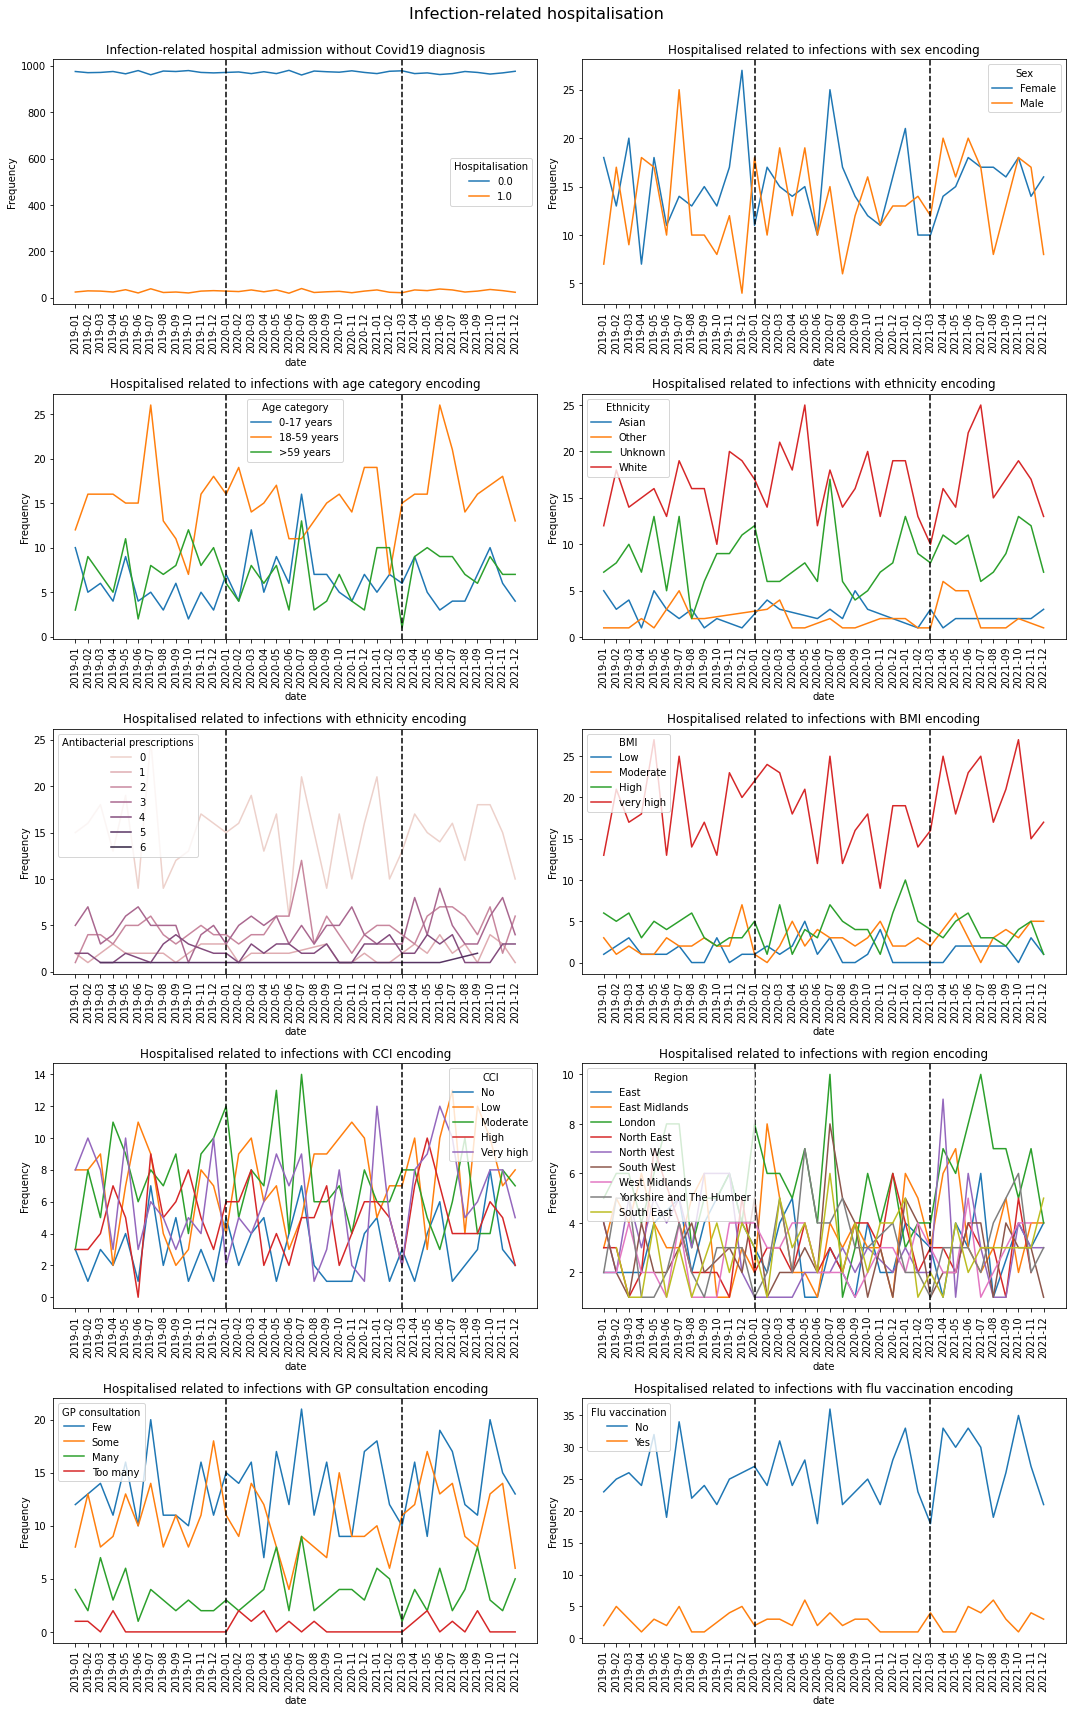

In [209]:
fig, axes = plt.subplots(5,2,
                        figsize=(15, 25)
                        )

create_lineplot('delta_primary_care_covid_admitted_binary', 'Infection-related hospital admission without Covid19 diagnosis', 'Hospitalisation', axes[0,0])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'sex', 'Hospitalised related to infections with sex encoding', 'Sex', axes[0,1])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'Age_cat', 'Hospitalised related to infections with age category encoding', 'Age category', axes[1,0])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'ethnicity', 'Hospitalised related to infections with ethnicity encoding', 'Ethnicity', axes[1,1])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'antibacterial_prescriptions', 'Hospitalised related to infections with ethnicity encoding', 'Antibacterial prescriptions', axes[2,0])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'BMI_cat', 'Hospitalised related to infections with BMI encoding', 'BMI', axes[2,1])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'CCI_cat', 'Hospitalised related to infections with CCI encoding', 'CCI', axes[3,0])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'region', 'Hospitalised related to infections with region encoding', 'Region', axes[3,1])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'gp_count_cat', 'Hospitalised related to infections with GP consultation encoding', 'GP consultation', axes[4,0])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'flu_vaccine', 'Hospitalised related to infections with flu vaccination encoding', 'Flu vaccination', axes[4,1])
# create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'covrx1_dat', 'Hospitalised related to infections with encoding of 1st Covid-19 Vaccine', '1st dose of Covid-19 vaccination', axes[5,0])
# create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'covrx2_dat', 'Hospitalised related to infections with encoding of 2nd Covid-19 Vaccine', '2nd dose of Covid-19 vaccination', axes[5,1])
#fig.delaxes(ax=axes[1,1])

fig.suptitle('Infection-related hospitalisation', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/infection-related hospitalisation.jpg')
plt.show()

### 3-3- Data inclusions and exclusions

In [211]:
# inclusion applied
data_inclusions = data[data['Infection_admitted_min_delta'].notnull()]
print(f'The shape of data with hospitalisation inclusion criterion is: {data_inclusions.shape}')

The shape of data with hospitalisation inclusion criterion is: (228, 94)


In [212]:
# exclusion applied
data_inclusions_exlusions = data_inclusions[(data_inclusions['delta_primary_care_covid_admitted'] < 390) & (data_inclusions['delta_primary_care_covid_admitted'] > -390)]  # exclusions shold be <90  and >-30
print(f'The shape of data with hospitalisation inclusion criterion and covid diagnosis exclusion criterion is: {data_inclusions_exlusions.shape}')

The shape of data with hospitalisation inclusion criterion and covid diagnosis exclusion criterion is: (14, 94)


In [213]:
data_inclusions_exlusions['delta_primary_care_covid_admitted'].value_counts()

-137.0    1
-308.0    1
 148.0    1
-55.0     1
 118.0    1
-175.0    1
 182.0    1
-255.0    1
-190.0    1
-179.0    1
-268.0    1
-110.0    1
-1.0      1
 209.0    1
Name: delta_primary_care_covid_admitted, dtype: int64

In [151]:
# # select patients whom their delta date is between 90 and -30
# data_hosp = data[~data['delta_primary_care_covid_admitted'].isnull()]
# data_hosp.head()

### 3-4- Negative binomial regression

In [216]:
data_inclusions_exlusions#['delta_primary_care_covid_admitted_abs']

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,delta_uti_4_admitted,delta_lrti_1_admitted,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,Infection_admitted_min_delta,delta_primary_care_covid_admitted,delta_primary_care_covid_admitted_abs,delta_primary_care_covid_admitted_binary
4780,2020-12,NaN,NaN,NaN,NaN,NaN,2019-08-15,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,10.0,-137.0,137.0,1.0
6085,2019-07,NaN,NaN,NaN,2018-11,NaN,2020-12-01,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,17.0,-308.0,308.0,1.0
6522,2021-06,2021-10,NaN,NaN,NaN,NaN,2021-04-18,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,10.0,148.0,148.0,1.0
18279,2020-07,NaN,NaN,2018-12,NaN,NaN,2019-03-16,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,8.0,-55.0,55.0,1.0
18531,2020-06,2021-09,NaN,NaN,NaN,NaN,2021-06-28,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,118.0,118.0,1.0
18711,2020-09,NaN,NaN,NaN,NaN,NaN,2020-07-07,NaT,NaN,NaN,...,NaN,NaN,NaN,26.0,NaN,1.0,26.0,-175.0,175.0,1.0
21252,2020-10,2020-05,NaN,NaN,2018-10,NaN,2020-11-28,NaT,NaN,NaN,...,NaN,NaN,17.0,NaN,NaN,1.0,17.0,182.0,182.0,1.0
23083,2021-09,NaN,NaN,NaN,2018-08,NaN,2020-01-12,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,18.0,-255.0,255.0,1.0
24965,2021-02,NaN,NaN,NaN,NaN,NaN,2020-12-31,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,3.0,-190.0,190.0,1.0
26413,2019-10,NaN,NaN,NaN,NaN,NaN,2019-09-27,NaT,NaN,NaN,...,NaN,NaN,NaN,24.0,NaN,1.0,24.0,-179.0,179.0,1.0


In [217]:
# # assigning 0 to NaN cells of delta_primary_care_covid_admitted_abs for compatibility of NB model
# data['delta_primary_care_covid_admitted_abs'] = data['delta_primary_care_covid_admitted_abs'].fillna(0)
# data['delta_primary_care_covid_admitted_abs'].value_counts()

In [179]:
data_NB = data.groupby(['date', 'sex']).size()#.reset_index()
data_NB.head()

date     sex
2019-01  1      514
         2      486
2019-02  1      510
         2      490
2019-03  1      535
dtype: int64

In [180]:
data_NB = data.groupby(['date']).mean()#.reset_index()
data_NB.head()

,covrx1_dat,covrx2_dat,age,sex,practice,imd,bmi,ethnicity,smoking_status,gp_count,...,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,CCI,delta_primary_care_covid_admitted,delta_primary_care_covid_admitted_abs,delta_primary_care_covid_admitted_binary
date,,,,,,,,,,,,,,,,,,,,,
2019-01,NaN,NaN,40.578,1.486,24.434,2.854,35.041677,1.168,2.076,3.428715,...,0.1,0.1,0.1,0.1,0.1,4950.415,4.443,14.500000,0.087,0.002
2019-02,NaN,NaN,39.453,1.490,24.545,2.913,34.974168,1.192,2.081,3.413724,...,0.1,0.1,0.1,0.1,0.1,5094.633,4.347,32.500000,0.101,0.002
2019-03,NaN,NaN,40.614,1.465,24.529,2.884,35.040573,1.166,2.068,3.323589,...,0.1,0.1,0.1,0.1,0.1,4961.472,4.398,24.666667,0.104,0.003
2019-04,NaN,NaN,40.320,1.483,24.487,2.861,35.109722,1.200,2.107,3.333333,...,0.1,0.1,0.1,0.1,0.1,5075.188,4.413,41.000000,0.082,0.002
2019-05,NaN,NaN,41.260,1.475,24.414,2.841,34.837915,1.260,2.089,3.361531,...,0.1,0.1,0.1,0.1,0.1,4970.181,4.503,16.000000,0.090,0.003


In [108]:
X = data_NB[['age', 
#          'sex', 
#          'ethnicity', 
#          'smoking_status',
          'CCI',
          'imd',
          'flu_vaccine',
          'delta_primary_care_covid_admitted_abs',
          ]]
y = data_NB['delta_primary_care_covid_admitted_binary']

In [109]:
# # splitting data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# print(f'y_train: {y_train.shape}')
# print(f'X_train: {X_train.shape}')
# print(f'y_test: {y_test.shape}')
# print(f'X_test: {X_test.shape}')

In [110]:
# nb2_training_results = sm.GLM(y_train, 
#                               X_train,
#                               family=sm.families.NegativeBinomial(alpha=1)).fit()

nb2_training_results = sm.GLM(y, 
                              X,
                              family=sm.families.NegativeBinomial(alpha=1)).fit()

In [111]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Generalized Linear Model Regression Results                             
====================================================================================================
Dep. Variable:     delta_primary_care_covid_admitted_binary   No. Observations:                   36
Model:                                                  GLM   Df Residuals:                       31
Model Family:                              NegativeBinomial   Df Model:                            4
Link Function:                                          Log   Scale:                          1.0000
Method:                                                IRLS   Log-Likelihood:               -0.75166
Date:                                      Wed, 08 Dec 2021   Deviance:                     0.010769
Time:                                              13:00:13   Pearson chi2:                  0.00908
No. Iterations:                                           4   Pseudo R-squ. (CS):          0.0003923
Covariance Type:                                  nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
age                                       0.1575     13.119      0.012      0.990     -25.554      25.869
CCI                                      -2.8074    195.513     -0.014      0.989    -386.006     380.392
imd                                      -0.5508     66.009     -0.008      0.993    -129.927     128.825
flu_vaccine                              12.1008   4552.232      0.003      0.998   -8910.111    8934.312
delta_primary_care_covid_admitted_abs     5.0159     42.181      0.119      0.905     -77.658      87.690
=========================================================================================================
"""

In [112]:
# nb2_predictions = nb2_training_results.get_prediction(X_test)
nb2_predictions = nb2_training_results.get_prediction(X)

In [113]:
nb2predictions_summary_frame = nb2_predictions.summary_frame()
print(nb2predictions_summary_frame)

             mean   mean_se  mean_ci_lower  mean_ci_upper
date                                                     
2019-01  0.002459  0.016346   5.411378e-09   1.117678e+03
2019-02  0.002801  0.014057   1.497021e-07   5.240347e+01
2019-03  0.003006  0.015903   9.440053e-08   9.572336e+01
2019-04  0.002496  0.011799   2.358881e-07   2.640254e+01
2019-05  0.002366  0.023893   5.982353e-12   9.354719e+05
2019-06  0.001692  0.011299   3.507017e-09   8.164777e+02
2019-07  0.002508  0.033550   1.025920e-14   6.129663e+08
2019-08  0.002245  0.012310   4.827598e-08   1.044028e+02
2019-09  0.003092  0.023385   1.131559e-09   8.451571e+03
2019-10  0.003498  0.015153   7.180248e-07   1.703777e+01
2019-11  0.002968  0.019701   6.643510e-09   1.325983e+03
2019-12  0.003899  0.020338   1.413265e-07   1.075419e+02
2020-01  0.005265  0.031245   4.681635e-08   5.922073e+02
2020-02  0.002177  0.017750   2.499594e-10   1.896093e+04
2020-03  0.003891  0.018164   4.134691e-07   3.661562e+01
2020-04  0.002

In [114]:
# X_test = X_test.apply(lambda x: x.sort_values(ascending=False))
# X_test

X = X.apply(lambda x: x.sort_values(ascending=False))
X

,age,CCI,imd,flu_vaccine,delta_primary_care_covid_admitted_abs
date,,,,,
2019-01,40.578,4.443,2.854,0.1,0.087
2019-02,39.453,4.347,2.913,0.1,0.101
2019-03,40.614,4.398,2.884,0.1,0.104
2019-04,40.320,4.413,2.861,0.1,0.082
2019-05,41.260,4.503,2.841,0.1,0.090
2019-06,40.760,4.428,2.869,0.1,0.000
2019-07,39.062,4.341,2.732,0.1,0.068
2019-08,40.688,4.428,2.836,0.1,0.055
2019-09,40.546,4.382,2.840,0.1,0.098


In [115]:
# add admitted date from data_hosp dataframe by lookup; then sorted with admitted dates
#X_test['delta_primary_care_covid_admitted_abs'] = data_NB['delta_primary_care_covid_admitted_abs'].loc[X_test.index]
X['delta_primary_care_covid_admitted_abs'] = data_NB['delta_primary_care_covid_admitted_abs'].loc[X.index]
#X_test = X_test.sort_values(by=['delta_primary_care_covid_admitted_abs'])

In [116]:
#X

In [117]:
#y

In [118]:
NB_predicted_counts=nb2predictions_summary_frame['mean']
NB_predicted_counts

date
2019-01    0.002459
2019-02    0.002801
2019-03    0.003006
2019-04    0.002496
2019-05    0.002366
2019-06    0.001692
2019-07    0.002508
2019-08    0.002245
2019-09    0.003092
2019-10    0.003498
2019-11    0.002968
2019-12    0.003899
2020-01    0.005265
2020-02    0.002177
2020-03    0.003891
2020-04    0.002091
2020-05    0.003354
2020-06    0.001848
2020-07    0.004157
2020-08    0.002451
2020-09    0.005578
2020-10    0.001852
2020-11    0.004538
2020-12    0.003231
2021-01    0.001617
2021-02    0.002623
2021-03    0.002335
2021-04    0.004498
2021-05    0.003038
2021-06    0.003545
2021-07    0.002086
2021-08    0.001705
2021-09    0.003296
2021-10    0.004844
2021-11    0.006289
2021-12    0.002662
Name: mean, dtype: float64

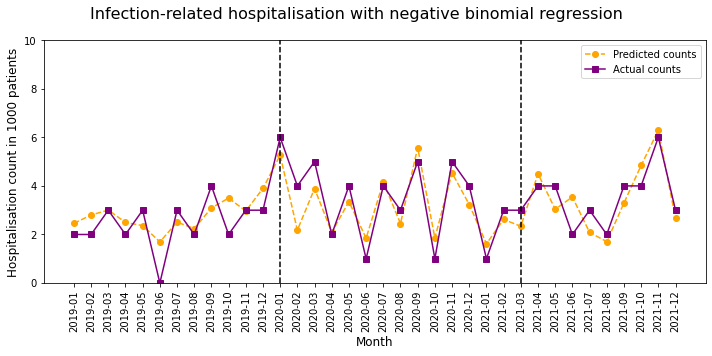

In [120]:
NB_predicted_counts=nb2predictions_summary_frame['mean']*1000
actual_counts = y*1000

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Infection-related hospitalisation with negative binomial regression', fontsize=16)
predicted, = plt.plot(X.index, NB_predicted_counts, color='orange', ls='dashed', marker='o', label='Predicted counts',
                    #'go--', 
                    )
actual, = plt.plot(X.index, actual_counts, color='purple', ls='solid', marker='s', label='Actual counts'
                    #'ro-', 
                    )
#plt.ylim(-0.1,1.1)

plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-03", color='black', ls='--', lw=1.5)

plt.legend(handles=[predicted, actual])
plt.xticks(rotation=90,) 
            #ha='right')
#plt.grid()
plt.ylabel('Hospitalisation count in 1000 patients', fontsize='12')
plt.xlabel('Month', fontsize='12')
plt.ylim(0,10)
plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/NB2_hosp.jpg')
plt.show()

In [218]:
data_inclusions_exlusions

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,delta_uti_4_admitted,delta_lrti_1_admitted,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,Infection_admitted_min_delta,delta_primary_care_covid_admitted,delta_primary_care_covid_admitted_abs,delta_primary_care_covid_admitted_binary
4780,2020-12,NaN,NaN,NaN,NaN,NaN,2019-08-15,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,10.0,-137.0,137.0,1.0
6085,2019-07,NaN,NaN,NaN,2018-11,NaN,2020-12-01,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,17.0,-308.0,308.0,1.0
6522,2021-06,2021-10,NaN,NaN,NaN,NaN,2021-04-18,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,10.0,148.0,148.0,1.0
18279,2020-07,NaN,NaN,2018-12,NaN,NaN,2019-03-16,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,8.0,-55.0,55.0,1.0
18531,2020-06,2021-09,NaN,NaN,NaN,NaN,2021-06-28,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,2.0,118.0,118.0,1.0
18711,2020-09,NaN,NaN,NaN,NaN,NaN,2020-07-07,NaT,NaN,NaN,...,NaN,NaN,NaN,26.0,NaN,1.0,26.0,-175.0,175.0,1.0
21252,2020-10,2020-05,NaN,NaN,2018-10,NaN,2020-11-28,NaT,NaN,NaN,...,NaN,NaN,17.0,NaN,NaN,1.0,17.0,182.0,182.0,1.0
23083,2021-09,NaN,NaN,NaN,2018-08,NaN,2020-01-12,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,18.0,-255.0,255.0,1.0
24965,2021-02,NaN,NaN,NaN,NaN,NaN,2020-12-31,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,3.0,-190.0,190.0,1.0
26413,2019-10,NaN,NaN,NaN,NaN,NaN,2019-09-27,NaT,NaN,NaN,...,NaN,NaN,NaN,24.0,NaN,1.0,24.0,-179.0,179.0,1.0


In [253]:
# define dictionaries

# dict_sex = {'Female': 1, 'Male': 2}
# dict_ethnicity = {'White': 1, 'Mixed': 2, 'Asian': 3, 'Black': 4, 'Other': 5, 'Unknown': 0}
# dict_smoking = {'Ex-smoker': 1, 'Unknown': 2, 'Smoker': 3, 'Never smoked': 4, np.nan: 2}
dict_imd = {'Unknown': 0, '1 (most deprived)': 1, '2': 2, '3': 3, '4': 4, '5 (least deprived)': 5}
dict_flu = {'No': 0, 'Yes': 1}
#dic_delta_primary_care_covid_admitted_abs = {'No': 0, 'Yes': 1}

# reoplace values of dictionaries with existing ones

# data_inclusions_exlusions = data_inclusions_exlusions.replace({"sex": dict_sex})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"ethnicity": dict_ethnicity})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"smoking_status": dict_smoking})
data_inclusions_exlusions = data_inclusions_exlusions.replace({"imd": dict_imd})
data_inclusions_exlusions = data_inclusions_exlusions.replace({"flu_vaccine": dict_flu})

In [274]:
data_NB = data_inclusions_exlusions.groupby(['Infection_admitted_min_delta']).mean()#.reset_index()
#data_NB = data_NB.drop([0])
data_NB#.head()

,covrx1_dat,covrx2_dat,age,practice,imd,bmi,gp_count,flu_vaccine_tpp,flu_vaccine,antibacterial_prescriptions,...,delta_uti_3_admitted,delta_uti_4_admitted,delta_lrti_1_admitted,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,delta_primary_care_covid_admitted,delta_primary_care_covid_admitted_abs,delta_primary_care_covid_admitted_binary
Infection_admitted_min_delta,,,,,,,,,,,,,,,,,,,,,
2.0,NaN,NaN,7.0,21.0,1.0,44.447351,7.0,0.0,0.0,0.0,...,2.0,NaN,NaN,NaN,NaN,NaN,1.0,118.0,118.0,1.0
3.0,NaN,NaN,30.5,22.0,3.0,42.099464,5.0,0.0,0.0,2.0,...,NaN,3.0,NaN,NaN,NaN,NaN,1.0,-229.0,229.0,1.0
4.0,NaN,NaN,24.0,24.0,2.0,60.663004,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,4.0,1.0,209.0,209.0,1.0
5.0,NaN,NaN,55.0,27.0,3.0,19.974079,3.0,0.0,0.0,2.0,...,NaN,5.0,NaN,NaN,NaN,NaN,1.0,-1.0,1.0,1.0
8.0,NaN,NaN,9.0,18.0,3.0,37.905900,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-55.0,55.0,1.0
10.0,NaN,NaN,45.0,22.5,1.5,24.254723,7.5,0.5,0.0,1.0,...,10.0,NaN,NaN,NaN,NaN,NaN,1.0,5.5,142.5,1.0
11.0,NaN,NaN,66.0,29.0,4.0,51.244826,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-110.0,110.0,1.0
17.0,NaN,NaN,24.5,26.5,2.5,33.131094,4.5,0.0,0.0,0.0,...,NaN,NaN,NaN,17.0,NaN,NaN,1.0,-63.0,245.0,1.0
18.0,NaN,NaN,39.0,29.0,3.0,49.747214,4.0,1.0,0.0,0.0,...,18.0,NaN,NaN,NaN,NaN,NaN,1.0,-255.0,255.0,1.0


In [275]:
data_NB.columns

Index(['covrx1_dat', 'covrx2_dat', 'age', 'practice', 'imd', 'bmi', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_count_1', 'lrti_ab_count_2', 'lrti_ab_count_3',
       'lrti_ab_count_4', 'cancer_comor', 'cardiovascular_comor',
       'chronic_obstructive_pulmonary_comor', 'heart_failure_comor',
       'connective_tissue_comor', 'dementia_comor', 'diabetes_comor',
       'diabetes_complications_comor', 'hemiplegia_comor', 'hiv_comor',
       'metastatic_cancer_comor', 'mild_liver_comor', 'mod_severe_liver_comor',
       'mod_severe_renal_comor', 'mi_comor', 'peptic_ulcer_c

In [340]:
X = data_NB[['age', 
#          'sex',
            'bmi',
#          'ethnicity', 
#          'smoking_status',
            'gp_count',
            'CCI',
            'imd',
            'flu_vaccine',
            'antibacterial_prescriptions',
#          'delta_primary_care_covid_admitted_abs',
          ]]
y = data_NB.index

In [341]:
nb2_training_results = sm.GLM(y, 
                              X,
                              family=sm.families.NegativeBinomial(alpha=1)).fit()

TypeError: 'Series' object is not callable

In [278]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   11
Model:                            GLM   Df Residuals:                        5
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.007
Date:                Thu, 09 Dec 2021   Deviance:                      0.90986
Time:                        13:12:52   Pearson chi2:                    0.756
No. Iterations:                     9   Pseudo R-squ. (CS):             0.3592
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
age                            -0.0003      0.019     -0.018      0.985      -0.037       0.036
bmi                            -0.0206      0.024     -0.850      0.395      -0.068       0.027
gp_count                        0.2971      0.138      2.158      0.031       0.027       0.567
CCI                            -0.3870      0.230     -1.679      0.093      -0.839       0.065
imd                             1.2122      0.396      3.060      0.002       0.436       1.989
flu_vaccine                          0          0        nan        nan           0           0
antibacterial_prescriptions    -0.4843      0.507     -0.956      0.339      -1.478       0.509
===============================================================================================
"""

In [338]:
# nb2_predictions = nb2_training_results.get_prediction(X_test)
nb2_predictions = nb2_training_results.get_prediction(X)

In [339]:
nb2predictions_summary_frame = nb2_predictions.summary_frame()
print(nb2predictions_summary_frame)

TypeError: 'Series' object is not callable

In [281]:
#X = X.apply(lambda x: x.sort_values(ascending=False))
#X

In [282]:
#X['delta_primary_care_covid_admitted_abs'] = data_NB['delta_primary_care_covid_admitted_abs'].loc[X.index]

In [283]:
X

,age,bmi,gp_count,CCI,imd,flu_vaccine,antibacterial_prescriptions
Infection_admitted_min_delta,,,,,,,
2.0,7.0,44.447351,7.0,4.0,1.0,0.0,0.0
3.0,30.5,42.099464,5.0,4.0,3.0,0.0,2.0
4.0,24.0,60.663004,0.0,0.0,2.0,0.0,0.0
5.0,55.0,19.974079,3.0,4.0,3.0,0.0,2.0
8.0,9.0,37.905900,0.0,2.0,3.0,0.0,0.0
10.0,45.0,24.254723,7.5,2.5,1.5,0.0,1.0
11.0,66.0,51.244826,0.0,3.0,4.0,0.0,0.0
17.0,24.5,33.131094,4.5,0.5,2.5,0.0,0.0
18.0,39.0,49.747214,4.0,3.0,3.0,0.0,0.0


In [284]:
NB_predicted_counts=nb2predictions_summary_frame['mean']
NB_predicted_counts

Infection_admitted_min_delta
2.0      2.288507
3.0      5.639317
4.0      3.220101
5.0      4.864945
8.0      8.008293
10.0     8.010805
11.0    13.629007
17.0    32.607513
18.0    13.849398
24.0    18.776781
26.0    21.401589
Name: mean, dtype: float64

In [285]:
y

Float64Index([2.0, 3.0, 4.0, 5.0, 8.0, 10.0, 11.0, 17.0, 18.0, 24.0, 26.0], dtype='float64', name='Infection_admitted_min_delta')

In [286]:
X#.index

,age,bmi,gp_count,CCI,imd,flu_vaccine,antibacterial_prescriptions
Infection_admitted_min_delta,,,,,,,
2.0,7.0,44.447351,7.0,4.0,1.0,0.0,0.0
3.0,30.5,42.099464,5.0,4.0,3.0,0.0,2.0
4.0,24.0,60.663004,0.0,0.0,2.0,0.0,0.0
5.0,55.0,19.974079,3.0,4.0,3.0,0.0,2.0
8.0,9.0,37.905900,0.0,2.0,3.0,0.0,0.0
10.0,45.0,24.254723,7.5,2.5,1.5,0.0,1.0
11.0,66.0,51.244826,0.0,3.0,4.0,0.0,0.0
17.0,24.5,33.131094,4.5,0.5,2.5,0.0,0.0
18.0,39.0,49.747214,4.0,3.0,3.0,0.0,0.0


In [303]:
y

Float64Index([2.0, 3.0, 4.0, 5.0, 8.0, 10.0, 11.0, 17.0, 18.0, 24.0, 26.0], dtype='float64', name='Infection_admitted_min_delta')

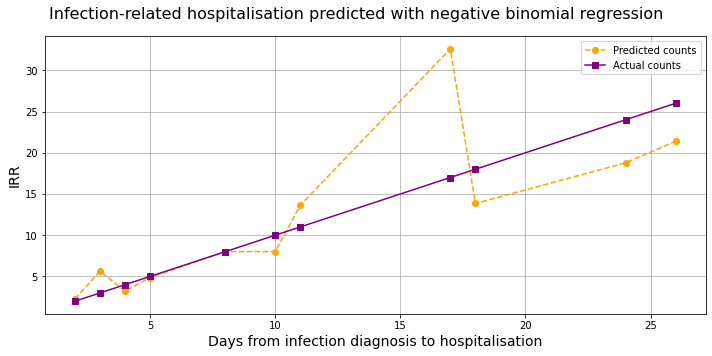

In [291]:
# ignore actual and predicted values in row 0
# NB_predicted_counts = nb2predictions_summary_frame['mean'].drop([0])*1000
NB_predicted_counts = nb2predictions_summary_frame['mean']#*1000
# actual_counts = y.drop([0])*1000
actual_counts = y#*1000

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Infection-related hospitalisation predicted with negative binomial regression', fontsize=16)
predicted, = plt.plot(X.index, NB_predicted_counts, color='orange', ls='dashed', marker='o', label='Predicted counts',
                    #'go--', 
                    )
actual, = plt.plot(X.index, actual_counts, color='purple', ls='solid', marker='s', label='Actual counts'
                    #'ro-', 
                    )
#plt.ylim(-0.1,1.1)

# plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
# plt.axvline(x="2021-03", color='black', ls='--', lw=1.5)

plt.legend(handles=[predicted, actual])
# plt.xticks(rotation=90,) 
#             #ha='right')
plt.grid()
plt.ylabel('IRR', fontsize='14')
plt.xlabel('Days from infection diagnosis to hospitalisation', fontsize='14')
# plt.ylim(0,10)
plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/NB2_hosp.jpg')
plt.show()

## Questions:
Q1- should we not exclude those who are admitted due to covid, not those who were diagnosed with covid 3 months before or two weeks after?

Q2- what is the difference between primary_care_covid and sgss_positive? seems like the first one is broader, right?

Q3- Data for NB2 model is not split into training and testing. Is it OK or it should be split?

Q4- I have used groupby to create data set for NB2. It calculates a mean value for each variable in each month. How is this gonna work with categorical variables?

Q5- If a patient gets hospitalise twice or more, I assume we consider the one that was closer to the infection diagnosis date, right?